# In this tutorial we will learn about how to use the [BIRCH algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.Birch.html) from [scikit-learn](https://scikit-learn.org/stable/index.html) with [ADTK library](https://adtk.readthedocs.io/en/stable/) to detect anomalous CPU behavior. 
## We will use the [InfluxDB Python Client](https://github.com/influxdata/influxdb-python) to query our data and return it as a Pandas DataFrame. 

## About the BIRCH algorithm: 

### What is it? 
"BIRCH (balanced iterative reducing and clustering using hierarchies) is an unsupervised data mining algorithm used to perform hierarchical clustering over particularly large data-sets. ... Its inventors claim BIRCH to be the "first clustering algorithm proposed in the database area to handle 'noise' (data points that are not part of the underlying pattern) effectively",[1] beating DBSCAN by two months. The algorithm received the SIGMOD 10 year test of time award in 2006.[2]" — ["BIRCH"](https://en.wikipedia.org/wiki/BIRCH), Wikipedia

### A brief introduction of the benefits of BIRCH
"Existing data clustering methods do not adequately address the problem of processing large datasets with a limited amount of resources (i.e. memory and cpu cycles). In consequence, as the dataset size increases, they scale poorly in terms of running time, and result quality. At a high level, Balanced Iterative Reducing and Clustering using Hierarchies, or BIRCH for short, deals with large datasets by first generating a more compact summary that retains as much distribution information as possible, and then clustering the data summary instead of the original dataset. BIRCH actually complements other clustering algorithms by virtue if the fact that different clustering algorithms can be applied to the summary produced by BIRCH. BIRCH can only deal with metric attributes (similar to the kind of features KMEANS can handle). A metric attribute is one whose values can be represented by explicit coordinates in an Euclidean space (no categorical variables)." —["BIRCH Clustering Algorithm Example In Python"](https://towardsdatascience.com/machine-learning-birch-clustering-algorithm-clearly-explained-fb9838cbeed9) by Cory Maklin

## About ADTK: 

### What is it?
Anomaly Detection Toolkit (ADTK) is a Python package for unsupervised / rule-based time series anomaly detection.

### Why are we using it? 

"This package offers a set of common detectors, transformers and aggregators with unified APIs, as well as pipe classes that connect them together into a model. It also provides some functions to process and visualize time series and anomaly events." — [ADTK Docs](https://adtk.readthedocs.io/en/stable/)

## About Sklearn: 
"Scikit-learn (formerly scikits.learn and also known as sklearn) is a free software machine learning library for the Python programming language.[3] It features various classification, regression and clustering algorithms including support vector machines, random forests, gradient boosting, k-means and DBSCAN, and is designed to interoperate with the Python numerical and scientific libraries NumPy and SciPy." — ["scikit-learn"](https://en.wikipedia.org/wiki/Scikit-learn), Wikepedia

## Step One:
Import Dependencies

In [1]:
import numpy as np
import pandas as pd
from numpy import sqrt
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from influxdb_client import InfluxDBClient
from adtk.detector import MinClusterDetector
from sklearn.cluster import Birch
from adtk.visualization import plot

## Step Two:  Use the Python InfluxDB Client to query our data 
- Gather the Auth parameters and store them in variables. 
- Create a Flux query to gather CPU data from local machine. The Flux query uses a pivot() and drop() to transform our data into the right shape. Or course, this data transformation can also be performed with Pandas. 
- Pass those variables into the client object and instantaite the client.
- Use the query_data_frame() method to return our data as Pandas DataFrame  

In [3]:
token = "mA8bUm45L_vtvxgS16Vn2o1tF3tzDfw0UIAkZgBW6LucfEGhT7bpvK2pbekfztrMWKtcyAOrVD-DWX3rPs8i1g=="
org = "my-org"
client = InfluxDBClient(url="http://localhost:9999", token=token, org=org)
query = '''from(bucket: "my-bucket")
  |> range(start: 2020-06-18T18:00:00Z ,  stop: 2020-06-20T02:00:00Z)
  |> filter(fn: (r) => r["_measurement"] == "cpu")
  |> filter(fn: (r) => r["_field"] == "usage_system")
  |> pivot(rowKey:["_time"], columnKey: ["cpu"], valueColumn: "_value")
  |> drop(columns:["_start", "_stop", "host", "_field", "_measurement"])'''
                                        
query_api = client.query_api()
df = query_api.query_data_frame(query)
df.head()

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,_time,cpu-total,cpu0,cpu1,cpu2,cpu3,cpu4,cpu5,cpu6,cpu7,result,table
0,2020-06-18 18:00:04+00:00,12.310961,24.124124,5.700000,21.021021,4.100000,19.58042,3.4,17.482517,3.096903,_result,0
1,2020-06-18 18:00:14+00:00,12.298463,25.500000,4.700000,21.778222,3.696304,19.61962,3.3,17.200000,2.600000,_result,0
2,2020-06-18 18:00:24+00:00,12.173478,24.324324,5.394605,20.920921,4.104104,19.10000,3.4,17.000000,3.100000,_result,0
3,2020-06-18 18:00:34+00:00,11.979492,23.453094,5.405405,21.500000,3.900000,18.80000,3.5,16.316316,3.000000,_result,0
4,2020-06-18 18:00:44+00:00,10.750000,23.523524,3.996004,19.600000,2.400000,17.20000,2.1,15.500000,1.700000,_result,0


In [7]:
df = pd.read_csv('Data/BIRCH.csv')
df.head()

FileNotFoundError: File b'Data/BIRCH.csv' does not exist

In [6]:
df.to_csv(r'/Users/anaisdotis-georgiou/Desktop/Everything/Repos/Notebooks/Anomaly_Detection/Data BIRCH.csv', index = False)

## Step Three: Data Transformation

- Perform remaining data tranformation to prep the DataFrame to be consumed by the [ADTK MinClusterDetector](https://adtk.readthedocs.io/en/stable/notebooks/demo.html#MinClusterDetector). MinClusterDetector treats multivariate time series as independent points in a high-dimensional space, divides them into clusters, and identifies values in the smallest cluster as anomalous. This may help capturing outliers in high-dimensional space.). 
- Ensure that the timestamp column is in the index and that it is a [datetime object](https://docs.python.org/3/library/datetime.html). 

In [70]:
df["_time"] = pd.to_datetime(df["_time"].astype(str))
df = df.drop(columns=["result", "table"])
df = df.set_index("_time")
df.head()

,cpu-total,cpu0,cpu1,cpu2,cpu3,cpu4,cpu5,cpu6,cpu7
_time,,,,,,,,,
2020-06-18 18:00:04,12.310961,24.124124,5.700000,21.021021,4.100000,19.58042,3.4,17.482517,3.096903
2020-06-18 18:00:14,12.298463,25.500000,4.700000,21.778222,3.696304,19.61962,3.3,17.200000,2.600000
2020-06-18 18:00:24,12.173478,24.324324,5.394605,20.920921,4.104104,19.10000,3.4,17.000000,3.100000
2020-06-18 18:00:34,11.979492,23.453094,5.405405,21.500000,3.900000,18.80000,3.5,16.316316,3.000000
2020-06-18 18:00:44,10.750000,23.523524,3.996004,19.600000,2.400000,17.20000,2.1,15.500000,1.700000


## Step Four: Use the [ADTK MinClusterDetector](https://adtk.readthedocs.io/en/stable/notebooks/demo.html#MinClusterDetector) function to implement sklearn's BIRCH algorithm on our dataframe.

### About MinClusterDetector: 

**ADTK MinClusterDetector** 

MinClusterDetector treats multivariate time series as independent points in a high-dimensional space, divides them into clusters, and identifies values in the smallest cluster as anomalous. This may help capturing outliers in high-dimensional space.

**Parameters (from the ADTK Docs)**

- epsfloat, default=0.5

The maximum distance between two samples for one to be considered as in the neighborhood of the other. This is not a maximum bound on the distances of points within a cluster. This is the most important DBSCAN parameter to choose appropriately for your data set and distance function.

- min_samplesint, default=5

The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself.

- metricstring, or callable, default=’euclidean’

The metric to use when calculating distance between instances in a feature array. If metric is a string or callable, it must be one of the options allowed by sklearn.metrics.pairwise_distances for its metric parameter. If metric is “precomputed”, X is assumed to be a distance matrix and must be square. X may be a Glossary, in which case only “nonzero” elements may be considered neighbors for DBSCAN.

- metric_paramsdict, default=None

Additional keyword arguments for the metric function.

- algorithm{‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}, default=’auto’

The algorithm to be used by the NearestNeighbors module to compute pointwise distances and find nearest neighbors. See NearestNeighbors module documentation for details.

- leaf_sizeint, default=30

Leaf size passed to BallTree or cKDTree. This can affect the speed of the construction and query, as well as the memory required to store the tree. The optimal value depends on the nature of the problem.

- pfloat, default=None

The power of the Minkowski metric to be used to calculate distance between points.

- n_jobsint or None, default=None

The number of parallel jobs to run. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors. 



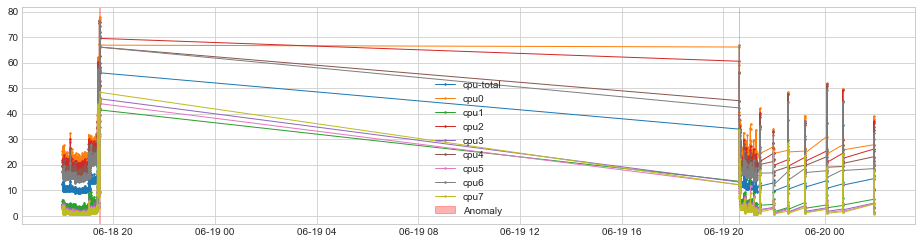

In [72]:
from adtk.detector import MinClusterDetector
from sklearn.cluster import Birch
from adtk.visualization import plot
min_cluster_detector = MinClusterDetector(Birch(n_clusters=10))
anomalies = min_cluster_detector.fit_detect(df)
plot(df, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_color='red', anomaly_alpha=0.3, curve_group='all')


Zooming in on the anomaly, BIRCH has detected an anomaly at 06-18-20 and 06-19-18.

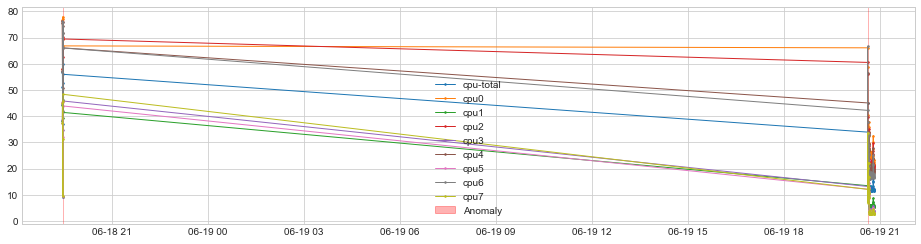

In [92]:
plot(df[520:600], anomaly=anomalies[520:600], ts_linewidth=1, ts_markersize=3, anomaly_color='red', anomaly_alpha=0.3, curve_group='all')